In [13]:
import os
import numpy as np
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.keras.models import Sequential
import joblib

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

Num GPUs Available:  0


In [14]:
data = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close Future,Open Future,High Future,Low Future
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0,236.929001,236.214005,237.798996,234.057007
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0,237.604996,236.955002,238.753006,236.794998
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0,236.153000,237.643997,237.697006,235.294998
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0,236.802002,236.009995,238.024994,236.009995
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0,233.128006,236.886993,237.210007,232.460007


In [15]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close Future', 'Open Future', 'High Future', 'Low Future'],
      dtype='object')

In [16]:
features = ['Close', 'Adj Close', 'Volume', 'Open', 'High', 'Low', 'Close Future']
df = data.dropna(subset=features)
data = df[features]

In [17]:
print(data.tail().to_json())

{"Close":{"3226":29856.5625,"3227":29913.92383,"3228":29792.01563,"3229":29908.74414,"3230":29771.80273},"Adj Close":{"3226":29856.5625,"3227":29913.92383,"3228":29792.01563,"3229":29908.74414,"3230":29771.80273},"Volume":{"3226":13138897269.0,"3227":12128602812.0,"3228":14655207121.0,"3229":10972789818.0,"3230":7873300598.0},"Open":{"3226":30147.07031,"3227":29862.04688,"3228":29915.25,"3229":29805.11133,"3230":29908.69727},"High":{"3226":30233.65625,"3227":30184.18164,"3228":30195.53125,"3229":30045.99805,"3230":29991.61523},"Low":{"3226":29556.42773,"3227":29794.26953,"3228":29638.0957,"3229":29733.85156,"3230":29664.12109},"Close Future":{"3226":73083.5,"3227":71396.59375,"3228":69403.77344,"3229":65315.11719,"3230":68556.4375}}


Text(0, 0.5, 'Close Price (USD)')

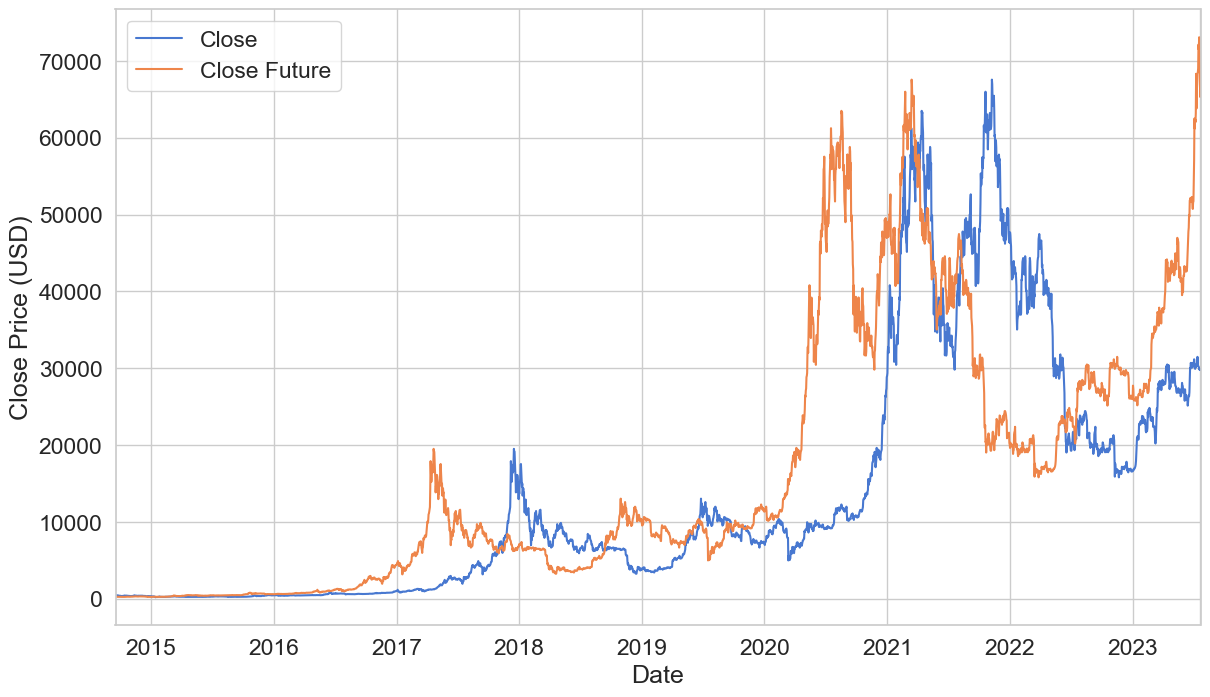

In [18]:
ax = df.plot(x='Date', y=['Close', 'Close Future']);
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

In [19]:
data.shape

(3231, 7)

In [20]:
features = ['Close', 'Adj Close', 'Volume', 'Open', 'High', 'Low']
X_normalized = data[features]
y_normalized = data[['Close Future']]
scaler_y = MinMaxScaler()
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_normalized)
y_normalized = scaler_y.fit_transform(y_normalized)

In [21]:
X_normalized.shape

(3231, 6)

In [22]:
y_normalized.shape

(3231, 1)

In [23]:
print(X_normalized.shape)
joblib.dump(scaler, 'scaler.gz')


(3231, 6)


['scaler.gz']

PREPROCESSING

In [24]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(X_raw, y_raw, seq_len, train_split):
    # data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])

    n_train_hours = 365 * 24
    X_train, X_test = X_raw[:num_train, :], X_raw[num_train:, :]
    y_train, y_test = y_raw[:num_train, -1], y_raw[num_train:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


    # X_train = data[:num_train, :-1, :]
    # y_train = data[:num_train, -1, :]

    # X_test = data[num_train:, :-1, :]
    # y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test =\
 preprocess(X_normalized, y_normalized, SEQ_LEN, train_split = 0.7)

(2261, 1, 6) (2261,) (970, 1, 6) (970,)


In [25]:
y_train.shape

(2261,)

MODEL

In [26]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

d:\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [27]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    verbose=2, 
    shuffle=False
)


Epoch 1/50
71/71 - 11s - 161ms/step - loss: 0.0179 - val_loss: 0.0598
Epoch 2/50
71/71 - 2s - 24ms/step - loss: 0.0382 - val_loss: 0.0527
Epoch 3/50
71/71 - 2s - 30ms/step - loss: 0.0256 - val_loss: 0.0538
Epoch 4/50
71/71 - 2s - 24ms/step - loss: 0.0325 - val_loss: 0.0488
Epoch 5/50
71/71 - 2s - 28ms/step - loss: 0.0347 - val_loss: 0.0399
Epoch 6/50
71/71 - 2s - 23ms/step - loss: 0.0353 - val_loss: 0.0792
Epoch 7/50
71/71 - 2s - 23ms/step - loss: 0.0277 - val_loss: 0.0437
Epoch 8/50
71/71 - 1s - 21ms/step - loss: 0.0304 - val_loss: 0.0421
Epoch 9/50
71/71 - 2s - 23ms/step - loss: 0.0255 - val_loss: 0.0377
Epoch 10/50
71/71 - 2s - 22ms/step - loss: 0.0281 - val_loss: 0.0412
Epoch 11/50
71/71 - 2s - 23ms/step - loss: 0.0248 - val_loss: 0.0349
Epoch 12/50
71/71 - 2s - 23ms/step - loss: 0.0260 - val_loss: 0.0380
Epoch 13/50
71/71 - 2s - 27ms/step - loss: 0.0249 - val_loss: 0.0373
Epoch 14/50
71/71 - 2s - 22ms/step - loss: 0.0249 - val_loss: 0.0382
Epoch 15/50
71/71 - 2s - 24ms/step - loss

In [28]:
model.evaluate(X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307


0.03314246982336044

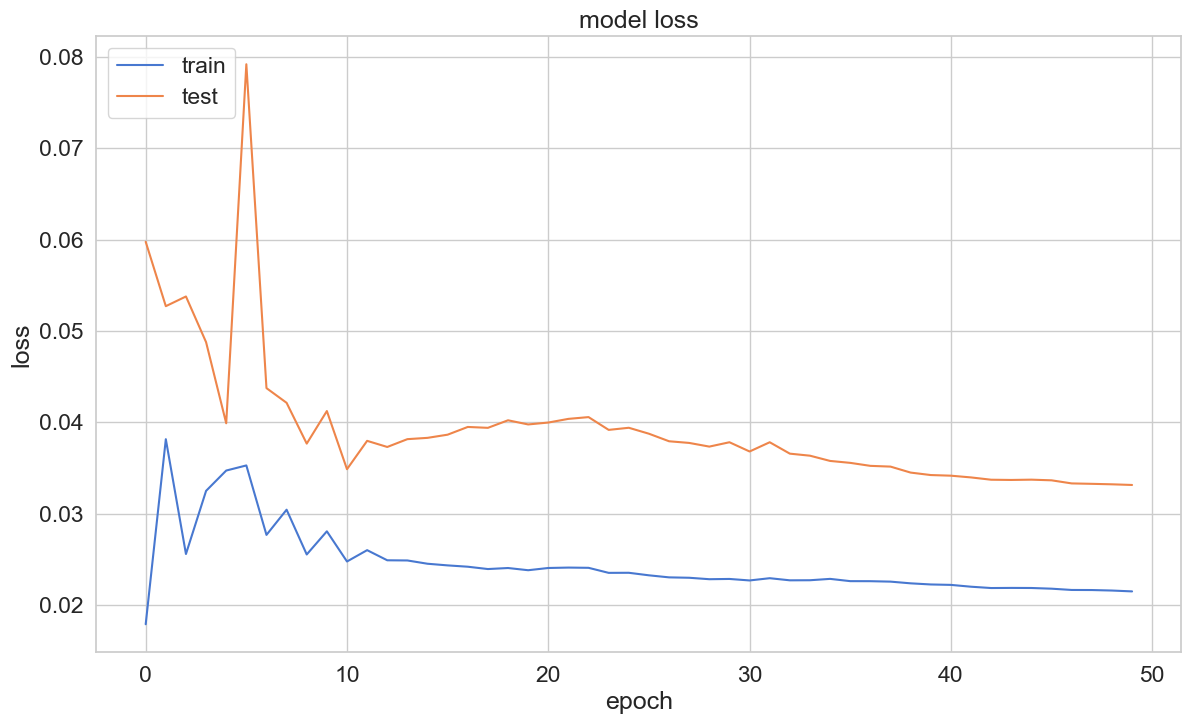

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
y_hat = model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [31]:
y_hat.shape

(970, 1)

In [32]:
y_test.shape

(970,)

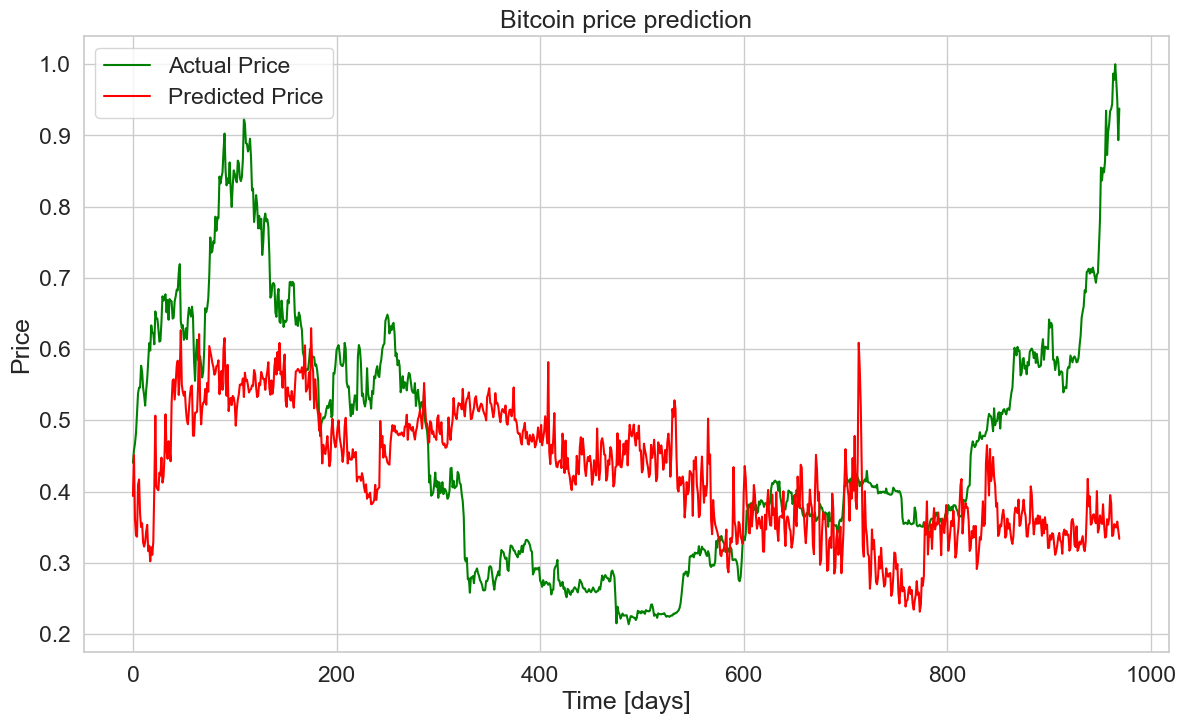

In [33]:
plt.plot(y_test, label="Actual Price", color='green')
plt.plot(y_hat, label="Predicted Price", color='red')
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

SAVE + DEPLOY

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 99, 198)        │        83,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 198)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 99, 396)        │       628,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 99, 396)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 198)            │       392,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           199 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,317,495 (12.66 MB)

 Trainable params: 1,105,831 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,211,664 (8.44 MB)

In [35]:
model.save('lstm.keras')

In [36]:
print(X_test.shape)

(970, 1, 6)


In [37]:
model.save(filepath='./1/', save_format='tf')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

docker run -p 8501:8501 --name tfserving_classifier --mount type=bind,source=\Users\pda131212\Model\LSTM\1,target=/models/lstm -e MODEL_NAME=lstm -t tensorflow/serving